# Laboratorium: Odchylenie standardowe, korelacja i energia w obrazach cyfrowych

**Cel ćwiczenia:** zapoznanie się z metrykami statystycznymi obrazów: odchylenie standardowe, energia oraz korelacja kierunkowa (pozioma, pionowa, ukośne).  
Notebook zawiera: teorię krótką, implementacje w Python, wykresy (obrazy, histogram, scatter), wizualizację 3D lokalnej wariancji oraz automatyczny generator raportu HTML do zapisu jako PDF.

**Uwaga:** przed uruchomieniem kodu upewnić się, że w katalogu roboczym znajdują się pliki obrazów (np. `4s.png`, `pink.png`, `lena.png`).  
Wymagane biblioteki: `numpy`, `matplotlib`, `opencv-python`, `scipy`, `seaborn`.  
Jeżeli brakuje biblioteki, zainstaluj ją lokalnie (np. `pip install seaborn`).


## Teoria — krótkie przypomnienie

### Odchylenie standardowe

$$
\sigma = \sqrt{
\frac{1}{MN}
\sum_{x=1}^{M}
\sum_{y=1}^{N}
\left( I(x,y) - \bar{I} \right)^2
}
$$

### Energia obrazu

$$
E = \sum_{x=1}^{M}
\sum_{y=1}^{N}
I(x,y)^2
$$

### Korelacja Pearsona (dla dwóch wektorów \(X\) i \(Y\))

$$
r =
\frac{
\sum (X_i - \bar{X})(Y_i - \bar{Y})
}{
\sqrt{\sum (X_i - \bar{X})^2}
\;
\sqrt{\sum (Y_i - \bar{Y})^2}
},
\qquad -1 \le r \le 1
$$

### Korelacje kierunkowe w obrazie

**Pozioma:**

$$
(I(x,y),\; I(x,y+1))
$$

**Pionowa:**

$$
(I(x,y),\; I(x+1,y))
$$

**Diagonalna ↘:**

$$
(I(x,y),\; I(x+1,y+1))
$$

**Diagonalna ↗:**

$$
(I(x,y),\; I(x-1,y+1))
$$

### Interpretacja wykresu rozrzutu

Każda kropka reprezentuje parę pikseli.  
Im bardziej punkty układają się wzdłuż prostej:

$$
y = x
$$

tym **większa korelacja** między kierunkowo dobranymi pikselami.


In [3]:
# Importy i ustawienia
import os
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.ndimage import generic_filter
from mpl_toolkits.mplot3d import Axes3D  # dla 3D
plt.rcParams['figure.figsize'] = (10,6)
sns.set(style="whitegrid")


In [5]:
# --- Funkcje pomocnicze ---

def safe_imread_gray(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Plik nie znaleziony: {path}")
    return img.astype(np.float32)

def compute_metrics(img):
    """Zwraca std, energy i korelacje kierunkowe."""
    img_f = img.astype(np.float64)
    std_val = float(np.std(img_f))
    energy = float(np.sum(img_f**2))

    # korelacje - obsługa wyjątków dla bardzo małych obrazów
    def corr(a, b):
        if a.size < 2 or b.size < 2:
            return float('nan')
        return float(pearsonr(a, b)[0])

    Xh, Yh = img_f[:, :-1].ravel(), img_f[:, 1:].ravel()
    Xv, Yv = img_f[:-1, :].ravel(), img_f[1:, :].ravel()
    Xd1, Yd1 = img_f[:-1, :-1].ravel(), img_f[1:, 1:].ravel()
    Xd2, Yd2 = img_f[1:, :-1].ravel(), img_f[:-1, 1:].ravel()

    return {
        'std': std_val,
        'energy': energy,
        'corr_h': corr(Xh, Yh),
        'corr_v': corr(Xv, Yv),
        'corr_d1': corr(Xd1, Yd1),
        'corr_d2': corr(Xd2, Yd2)
    }

def plot_image_and_hist(img, title=""):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.title(title)
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.hist(img.ravel(), bins=256, range=(0,255), color='gray')
    plt.title("Histogram intensywności")
    plt.xlabel("Intensywność")
    plt.ylabel("Liczność")
    plt.tight_layout()
    plt.show()

def plot_scatter_directions(img, sample_step=600):
    pairs = [
        ("Pozioma", img[:, :-1].ravel(), img[:, 1:].ravel()),
        ("Pionowa", img[:-1, :].ravel(), img[1:, :].ravel()),
        ("Diag ↘", img[:-1, :-1].ravel(), img[1:, 1:].ravel()),
        ("Diag ↗", img[1:, :-1].ravel(), img[:-1, 1:].ravel()),
    ]
    plt.figure(figsize=(12,10))
    for i,(name,X,Y) in enumerate(pairs,1):
        plt.subplot(2,2,i)
        step = max(1, X.size // (20000//(i)))  # adapt sampling
        plt.scatter(X[::step], Y[::step], s=1, alpha=0.3)
        plt.title(name)
        plt.xlabel("I")
        plt.ylabel("I_sąsiad")
        plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()


In [6]:
def local_variance(img, ksize=7):
    img_f = img.astype(np.float32)
    mean_local = cv2.blur(img_f, (ksize, ksize))
    mean_sq_local = cv2.blur(img_f**2, (ksize, ksize))
    var_local = mean_sq_local - mean_local**2
    var_local[var_local < 0] = 0.0
    return var_local

def plot_variance_2d_3d(var_map, downsample_step=None):
    plt.figure(figsize=(6,5))
    plt.imshow(var_map, cmap='inferno')
    plt.title("Mapa lokalnej wariancji (2D)")
    plt.axis('off')
    plt.colorbar()
    plt.show()

    # 3D wykres (próbkowanie dla wydajności)
    H, W = var_map.shape
    step = 1 if downsample_step is None else downsample_step
    step = max(1, min(step, max(1, min(H//100, W//100))))
    X = np.arange(0, W, step)
    Y = np.arange(0, H, step)
    Xg, Yg = np.meshgrid(X, Y)
    Z = var_map[::step, ::step]

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(Xg, Yg, Z, cmap='viridis', linewidth=0, antialiased=True)
    ax.set_title("Mapa lokalnej wariancji — 3D")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Wariancja")
    plt.show()


## 🗺️ Mapa lokalnej wariancji — interpretacja

**Mapa lokalnej wariancji** (local variance map) przedstawia przestrzenny rozkład zmienności intensywności pikseli w obrazie.  
Obliczana jest zazwyczaj w niewielkim oknie (np. \(3\times 3\), \(5\times 5\), \(11\times 11\)) wokół każdego piksela:

$$
\mathrm{Var}_{\text{local}}(x,y) =
\frac{1}{K}
\sum_{(i,j)\in\Omega}
\left( I(i,j) - \bar{I}_{\Omega} \right)^2
$$

gdzie:

- \( \Omega \) — lokalne okno wokół piksela \( (x,y) \),
- \( \bar{I}_{\Omega} \) — średnia intensywność w oknie,
- \( K \) — liczba pikseli w oknie.

---

### 🔍 Co przedstawia mapa lokalnej wariancji?

1. **Miara lokalnej zmienności intensywności**
   Regiony o dużych zmianach jasności (krawędzie, detale, faktury) mają wysoką wariancję.  
   Regiony jednorodne (tło gładkie, niebo, jednolite obszary) mają wariancję bliską zera.

2. **Wykrywanie krawędzi i szczegółów**
   Obszary o wysokiej lokalnej wariancji często pokrywają się z krawędziami i teksturą.

3. **Identyfikację szumu**
   Szum typu Gaussian powoduje wzrost lokalnej wariancji, szczególnie w regionach jednolitych.  
   Wysoka wariancja w gładkich strefach sugeruje obecność zakłóceń.

4. **Analizę tekstur**
   Tekstury drobne i intensywne → wysoka wariancja.  
   Powierzchnie gładkie → niska wariancja.

5. **Segmentację obrazu**
   Mapa wariancji może służyć do:
   - separacji regionów gładkich i szczegółowych,
   - klasyfikacji pikseli na podstawie zmienności,
   - poprawy wyników segmentacji opartej na progowaniu.

---

### 🎨 Jak wygląda mapa wariancji?

- **Ciemne obszary** → niska wariancja (fragmenty jednorodne).  
- **Jasne obszary** → wysoka wariancja (krawędzie, detale, szum).  
- **Bardzo jasne punkty** → piksele ekstremalne (wysoki kontrast lokalny, ostre granice).

---

### 📌 Podsumowanie

Mapa lokalnej wariancji:

- pokazuje zmienność intensywności w małych obszarach,
- identyfikuje krawędzie, detale, tekstury i szum,
- jest używana w segmentacji, detekcji krawędzi, filtracji adaptacyjnej i analizie struktury obrazu.

---

Chcesz, żebym dodała również **wizualizację 3D lokalnej wariancji** oraz kod do obliczania mapy wariancji?


## Instrukcja: analiza kilku obrazów

Wprowadź listę ścieżek do obrazów (zmienna `image_paths`) i uruchom kolejne komórki.  
Poniższe komórki wykonają: wczytanie, obliczenia metryk, wizualizacje i przygotowanie wyników do raportu HTML.



--- C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\3.jpg ---
Rozmiar: 431x363
STD: 46.642, Energy: 2.067e+09
Korelacje: H=0.9270, V=0.9409, D↘=0.8849, D↗=0.8892


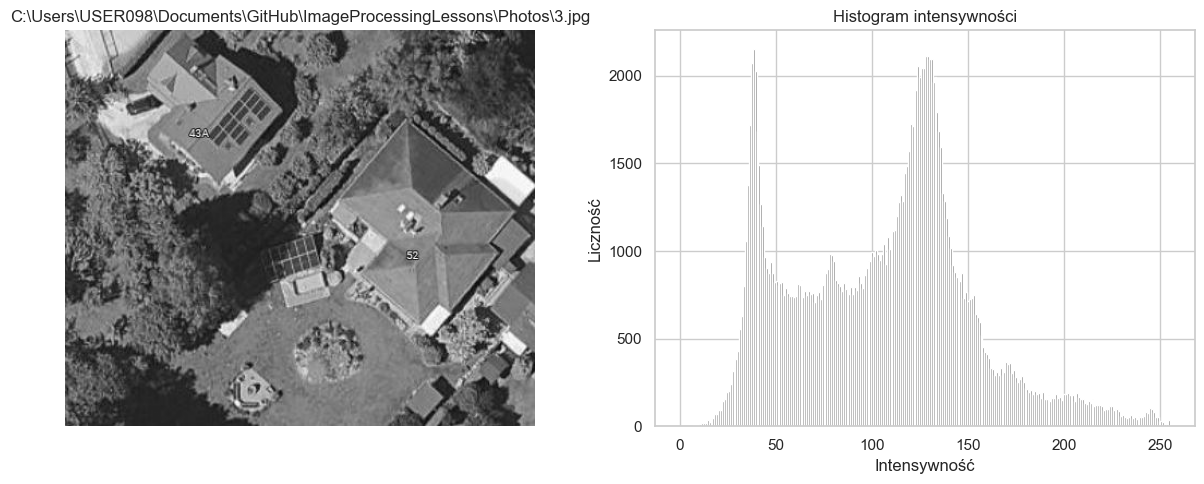

C:\Users\USER098\AppData\Local\Temp\ipykernel_20876\3958508917.py:66: UserWarning: Glyph 8600 (\N{SOUTH EAST ARROW}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\USER098\AppData\Local\Temp\ipykernel_20876\3958508917.py:66: UserWarning: Glyph 8599 (\N{NORTH EAST ARROW}) missing from font(s) Arial.
  plt.tight_layout()


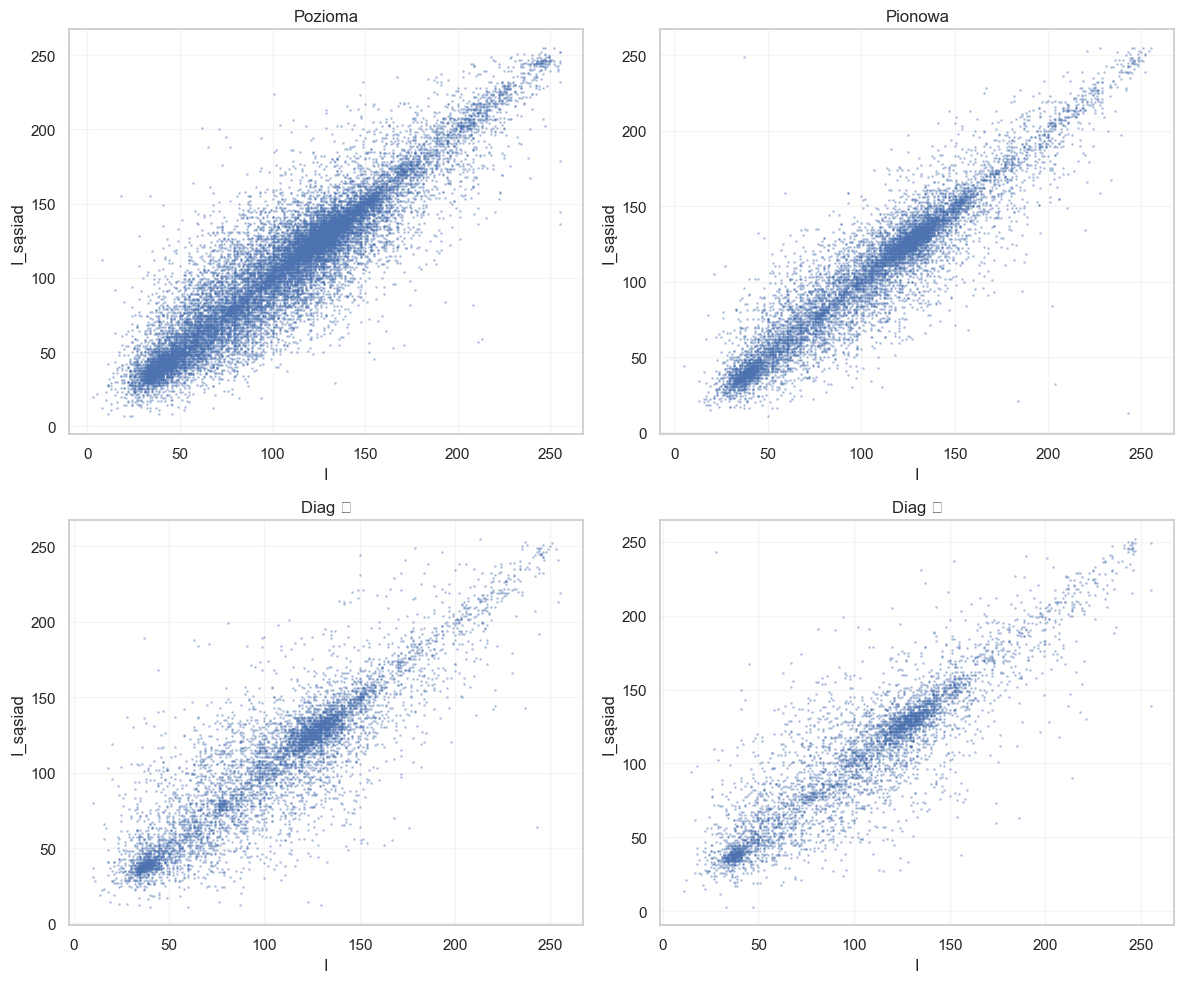

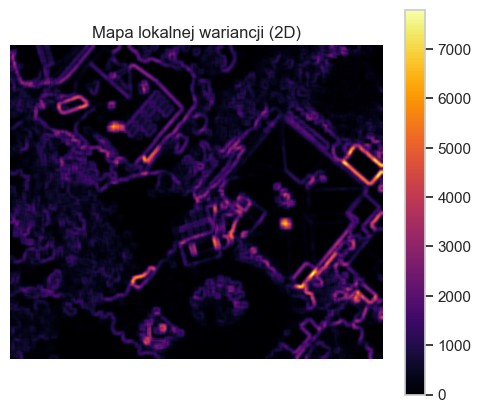

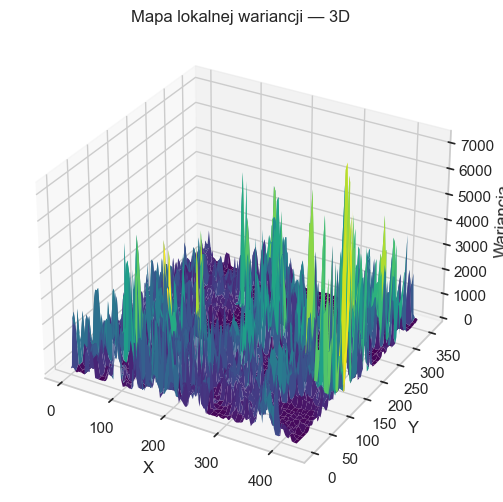

Uwaga: nie udało się zapisać wszystkich assetów: buffer is not large enough

--- C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\4.jpg ---
Rozmiar: 474x474
STD: 68.996, Energy: 2.824e+09
Korelacje: H=0.9508, V=0.9526, D↘=0.9161, D↗=0.9193


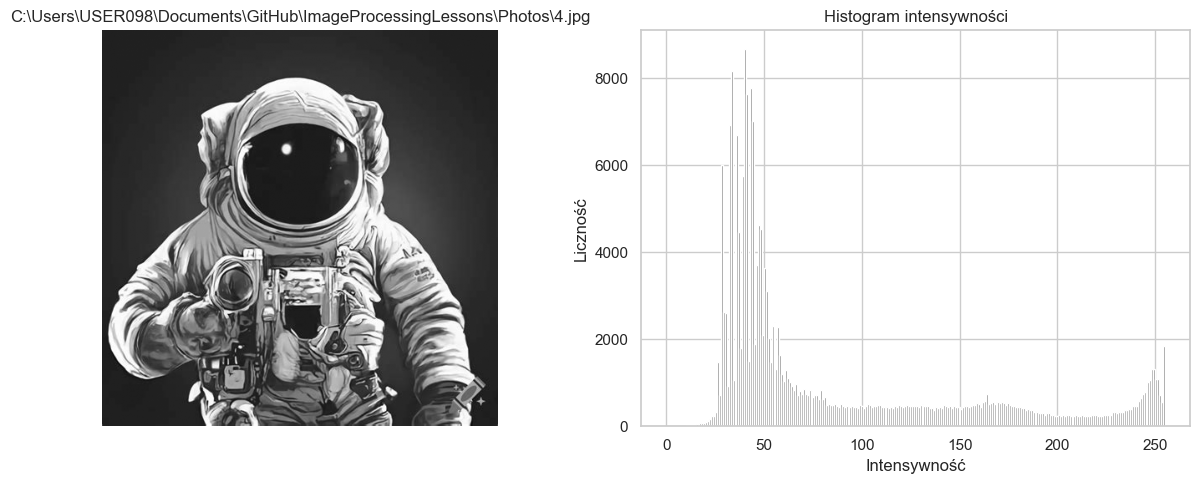

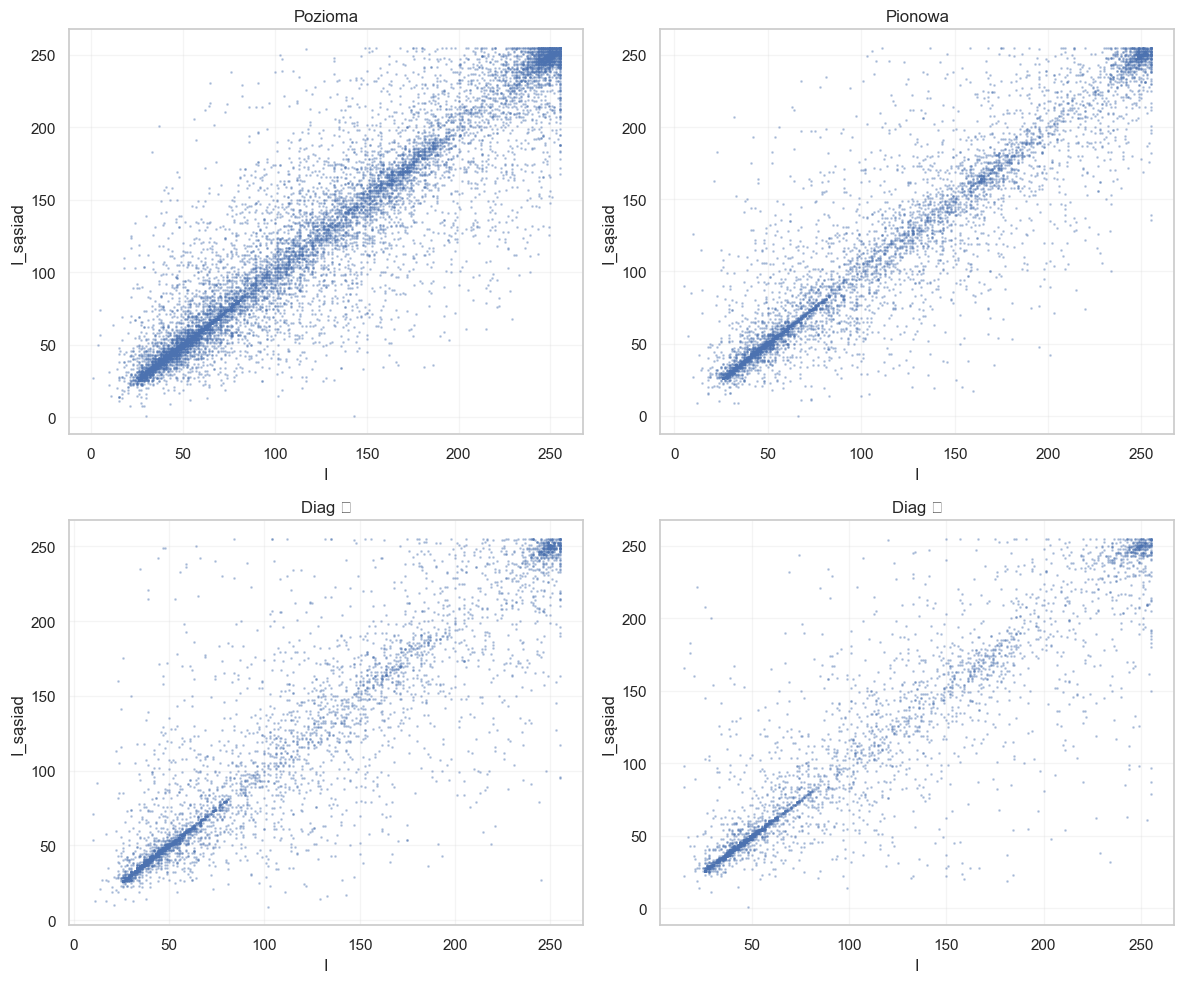

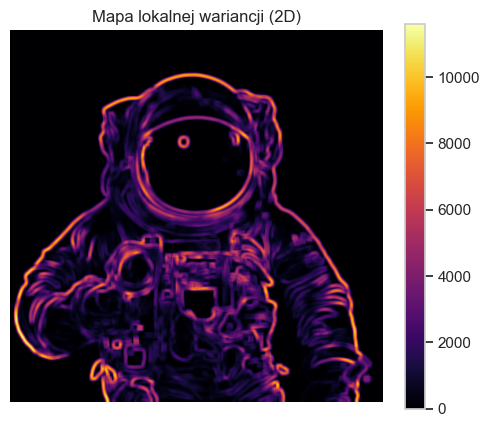

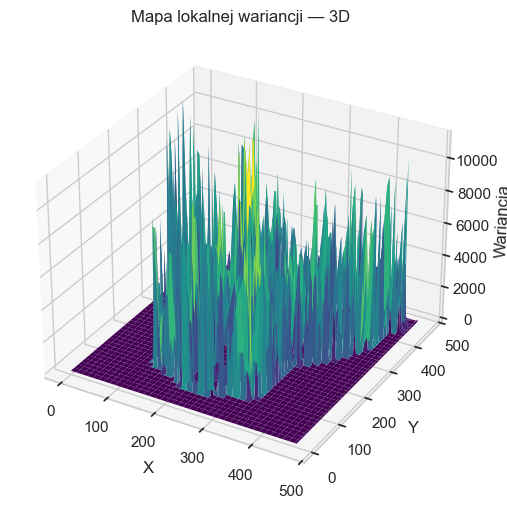

Uwaga: nie udało się zapisać wszystkich assetów: buffer is not large enough

--- C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\5.jpg ---
Rozmiar: 626x417
STD: 62.546, Energy: 4.556e+09
Korelacje: H=0.9831, V=0.9824, D↘=0.9717, D↗=0.9710


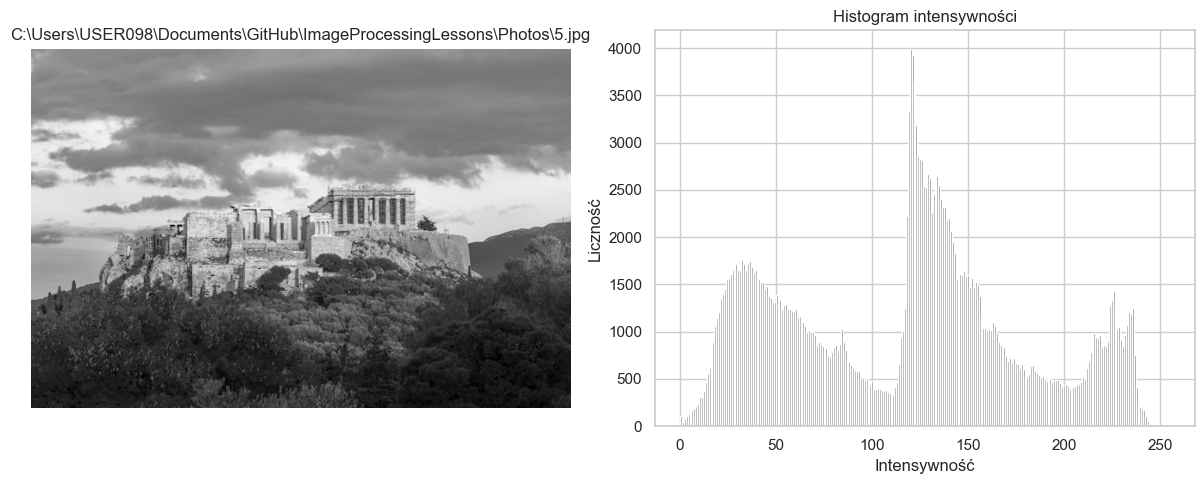

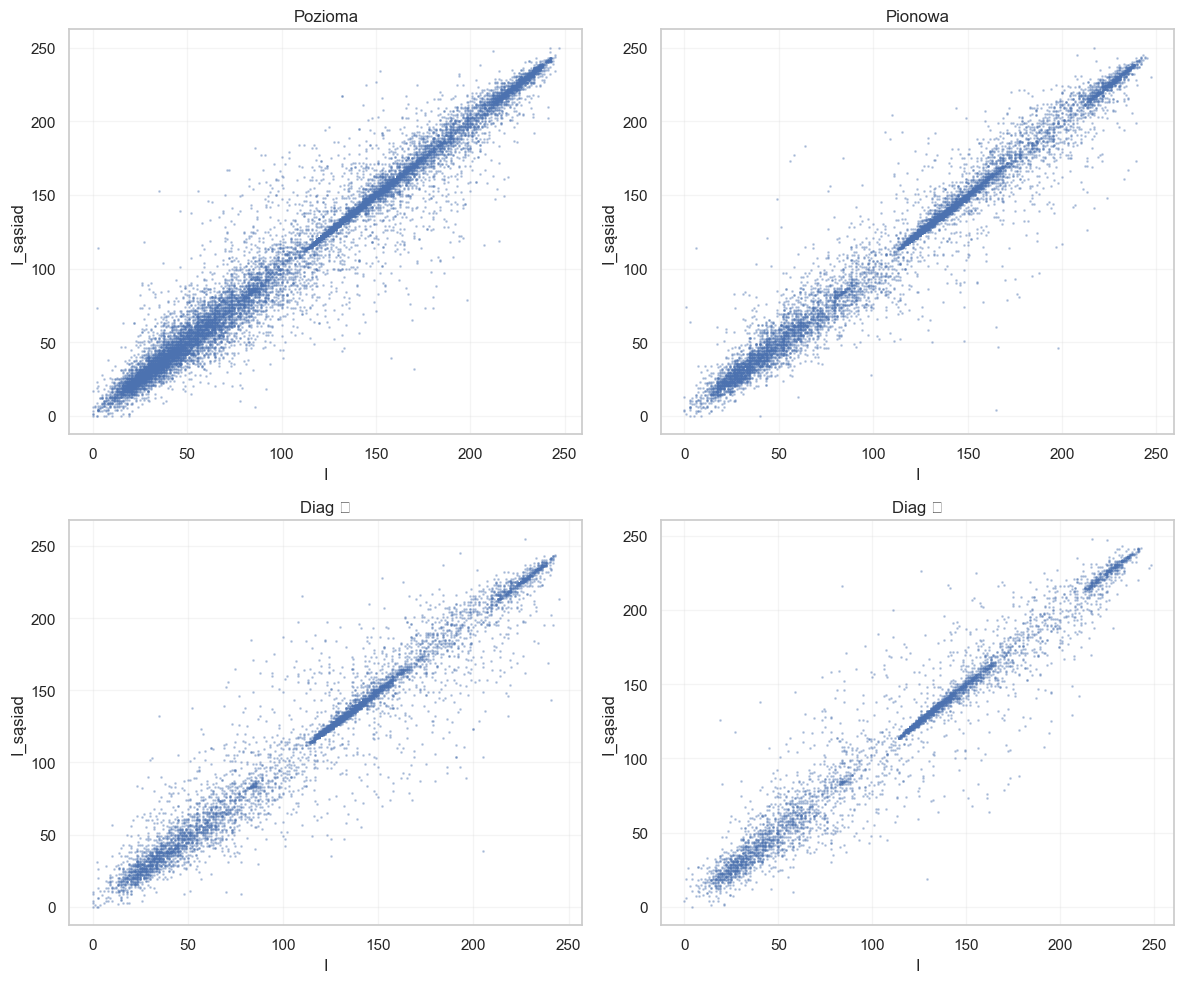

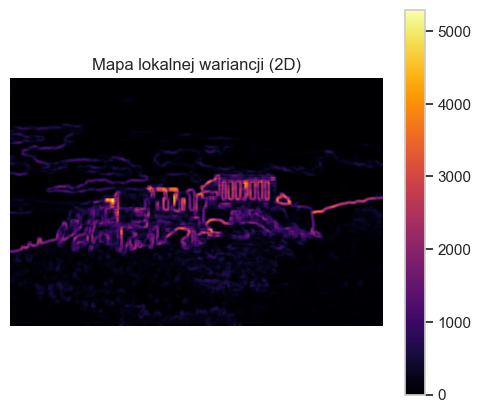

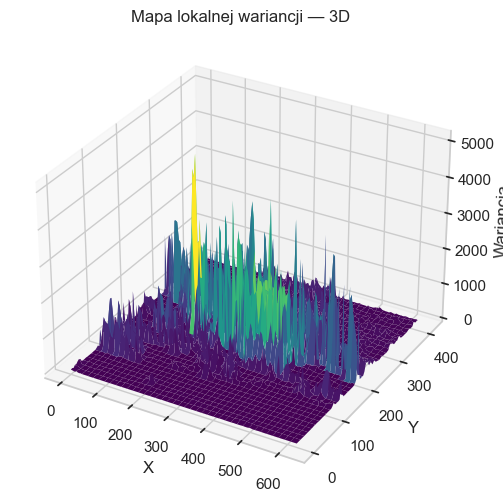

Uwaga: nie udało się zapisać wszystkich assetów: buffer is not large enough

--- C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\6.jpg ---
Rozmiar: 474x262
STD: 43.510, Energy: 8.648e+08
Korelacje: H=0.9207, V=0.9017, D↘=0.8495, D↗=0.8512


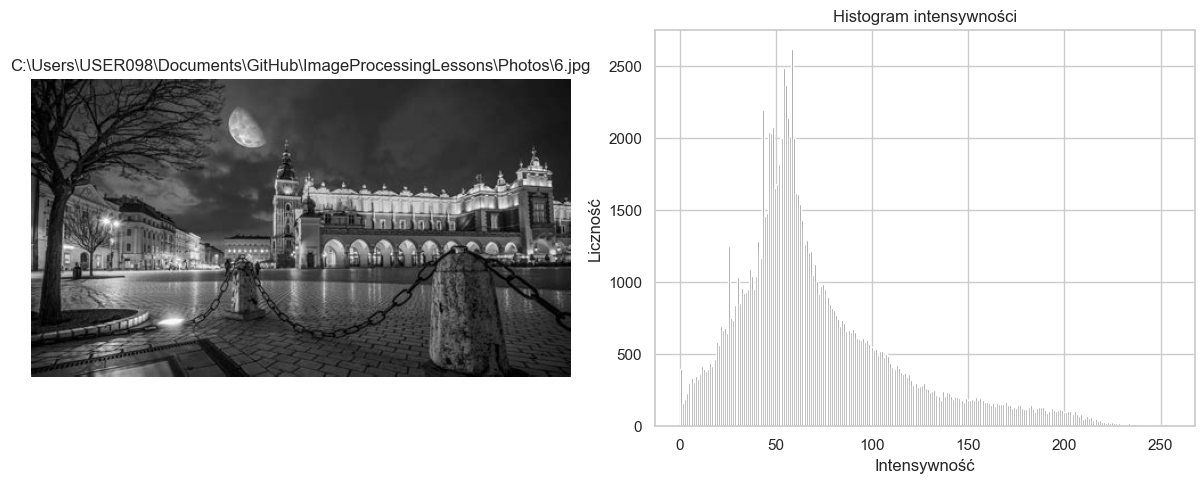

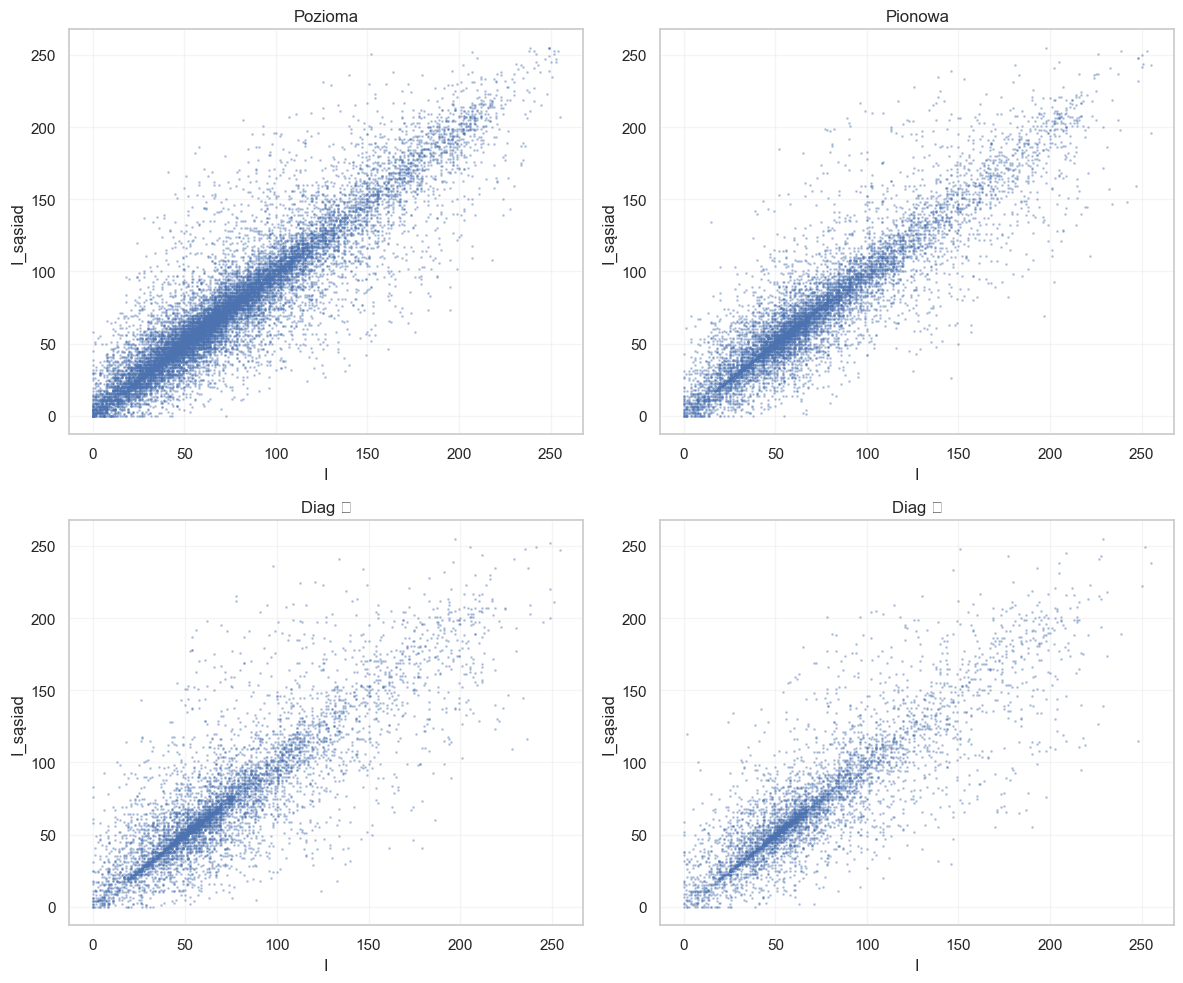

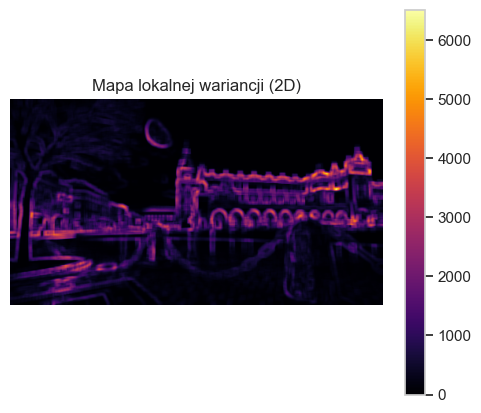

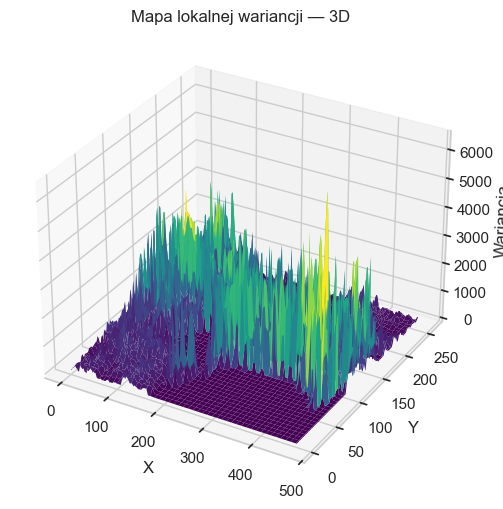

Uwaga: nie udało się zapisać wszystkich assetów: buffer is not large enough


In [8]:
# --- Ustaw listę plików (dostosuj ścieżki) ---

obraz1=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\3.jpg"
obraz2=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\4.jpg"
obraz3=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\5.jpg"
obraz4=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\6.jpg"

image_paths = [obraz1,obraz2,obraz3,obraz4]  # zmień na dostępne pliki

# katalog do zapisu wykresów pomocniczych (używany w raporcie HTML)
assets_dir = "report_assets"
os.makedirs(assets_dir, exist_ok=True)

results = {}
for path in image_paths:
    try:
        img = safe_imread_gray(path)
    except FileNotFoundError as e:
        print(e)
        continue

    metrics = compute_metrics(img)
    results[path] = {'metrics': metrics, 'shape': img.shape}

    print(f"\n--- {path} ---")
    print(f"Rozmiar: {img.shape[1]}x{img.shape[0]}")
    print(f"STD: {metrics['std']:.3f}, Energy: {metrics['energy']:.3e}")
    print(f"Korelacje: H={metrics['corr_h']:.4f}, V={metrics['corr_v']:.4f}, D↘={metrics['corr_d1']:.4f}, D↗={metrics['corr_d2']:.4f}")

    # Wizualizacje
    plot_image_and_hist(img, title=path)
    plot_scatter_directions(img)

    # lokalna wariancja i wizualizacja
    var_map = local_variance(img, ksize=7)
    plot_variance_2d_3d(var_map, downsample_step=6)

    # Zapis miniatur wykresów (do raportu)
    try:
        fn_base = os.path.splitext(os.path.basename(path))[0]
        plt.imsave(os.path.join(assets_dir, f"{fn_base}_img.png"), img, cmap='gray', vmin=0, vmax=255)
        plt.imsave(os.path.join(assets_dir, f"{fn_base}_hist.png"), np.histogram(img, bins=256)[0], cmap='gray')
        # scatter zapisz jako figura
        # (zapis scatter jako plik wymaga regeneracji figury; tutaj opcjonalnie pomijamy)
    except Exception as ex:
        print("Uwaga: nie udało się zapisać wszystkich assetów:", ex)


## Generator raportu HTML

Poniższy kod wygeneruje plik `raport_korelacje.html` zawierający tabelę wyników i osadzone miniatury (jeśli istnieją). Plik HTML można otworzyć w przeglądarce i zapisać jako PDF (Print → Save as PDF).


In [9]:
def generate_html_report(results_dict, image_paths, assets_dir="report_assets", output_html="raport_korelacje.html"):
    html = []
    html.append("<!doctype html>")
    html.append("<html><head><meta charset='utf-8'><title>Raport korelacji</title>")
    html.append("""<style>
        body {font-family: Arial, sans-serif; margin: 24px;}
        h1 {color:#003366;}
        table {border-collapse: collapse; width: 100%;}
        th, td {border: 1px solid #aaa; padding: 6px; text-align:center;}
        th {background:#e6f2ff;}
        img {max-width: 320px; height: auto; border:1px solid #ccc; margin:6px;}
        .section {margin-top: 20px;}
        </style>""")
    html.append("</head><body>")
    html.append("<h1>Raport: Analiza odchylenia, energii i korelacji kierunkowych</h1>")
    html.append("<p>Automatyczny raport wygenerowany z notebooka.</p>")

    # Tabela wyników
    html.append("<div class='section'><h2>Wyniki metryk</h2>")
    html.append("<table><tr><th>Plik</th><th>Rozmiar</th><th>STD</th><th>Energy</th><th>corr_H</th><th>corr_V</th><th>corr_D↘</th><th>corr_D↗</th></tr>")
    for path in image_paths:
        if path not in results_dict: continue
        info = results_dict[path]
        m = info['metrics']
        size = f"{info['shape'][1]}×{info['shape'][0]}"
        html.append(f"<tr><td>{os.path.basename(path)}</td><td>{size}</td><td>{m['std']:.3f}</td><td>{m['energy']:.2e}</td>"
                    f"<td>{m['corr_h']:.4f}</td><td>{m['corr_v']:.4f}</td><td>{m['corr_d1']:.4f}</td><td>{m['corr_d2']:.4f}</td></tr>")
    html.append("</table></div>")

    # Obrazy i miniatury
    html.append("<div class='section'><h2>Obrazy i miniatury</h2>")
    for path in image_paths:
        if path not in results_dict: continue
        base = os.path.splitext(os.path.basename(path))[0]
        img_fn = os.path.join(assets_dir, f"{base}_img.png")
        hist_fn = os.path.join(assets_dir, f"{base}_hist.png")
        html.append(f"<h3>{os.path.basename(path)}</h3>")
        if os.path.exists(img_fn):
            html.append(f"<img src='{img_fn}' alt='{base} image'>")
        if os.path.exists(hist_fn):
            html.append(f"<img src='{hist_fn}' alt='{base} hist'>")
    html.append("</div>")

    # Wnioski (automatyczne, proste)
    html.append("<div class='section'><h2>Wnioski automatyczne</h2>")
    for path in image_paths:
        if path not in results_dict: continue
        m = results_dict[path]['metrics']
        html.append(f"<h4>{os.path.basename(path)}</h4>")
        concl = []
        concl.append("obraz gładki" if m['corr_h']>0.95 and m['corr_v']>0.95 else "obraz z teksturą/szumem")
        concl.append("wysoka energia" if m['energy']>1e7 else "niska/średnia energia")
        html.append("<p>" + "; ".join(concl) + "</p>")
    html.append("<p><i>Raport wygenerowano automatycznie.</i></p>")
    html.append("</body></html>")

    with open(output_html, "w", encoding="utf-8") as f:
        f.write("\n".join(html))
    return output_html

# generuj
html_path = generate_html_report(results, image_paths, assets_dir=assets_dir, output_html="raport_korelacje.html")
print("Utworzono raport:", html_path)


Utworzono raport: raport_korelacje.html


## Pytania kontrolne (do zadania domowego)

1. Co mierzy odchylenie standardowe w obrazie i jakie są jego zastosowania?
2. Jak interpretować wartość korelacji Pearsona w kontekście obrazu?
3. Co oznacza wysoka energia obrazu?
4. Jak wpływa szum Gaussa na korelacje kierunkowe?
5. W jaki sposób można wykorzystać mapę lokalnej wariancji w zadaniu segmentacji?
6. Co pokazuje histogram błędu rekonstrukcji (DFT/DCT) i jak go interpretować?
7. Jakie zmiany w metrykach oczekujesz po zastosowaniu filtru Gaussa? po medianowym?
8. Jakie zastosowania praktyczne mają miary: std, energy, correlation?
9. Jakie są ograniczenia korelacji Pearsona w analizie obrazów?
10. W jaki sposób można rozszerzyć raport automatyczny o dodatkowe metryki (PSNR, SSIM)?
